In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier , GradientBoostingClassifier , ExtraTreesClassifier , VotingClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
sns.set(style='white' , context='notebook' , palette='deep')

import warnings
warnings.filterwarnings("ignore")

In [0]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
IDtest = test['PassengerId']
# Any results you write to the current directory are saved as output.

['train.csv', 'gender_submission.csv', 'test.csv']


In [0]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


<h2>Funtion to Detect Outlier</h2>

In [0]:
def detect_outliers(df, n, features , drop):
    outlier_indicies = []
    
    for col in features:
        Q1 = np.percentile(df[col] , 25)
        Q3 = np.percentile(df[col] , 75)
        #inter Quatile range
        IQR = Q3-Q1
        outlier_range = 1.5 * IQR
        row_index_OfOutliers = df[(df[col] < Q1 - outlier_range) | (df[col] > Q3 + outlier_range)].index
        outlier_indicies.extend(row_index_OfOutliers)
    OutlierIndex_count = Counter(outlier_indicies)
    RowWith_N_outlier = [row_index for row_index in OutlierIndex_count if OutlierIndex_count[row_index] > n]
    if drop == 1:
        df = df.drop(RowWith_N_outlier , axis=0).reset_index(drop=True)
        return df
    return RowWith_N_outlier
print(train.shape)
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"] , drop=0)
train.loc[Outliers_to_drop] # Show the outliers rows

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [0]:
train = detect_outliers(train,2,["Age","SibSp","Parch","Fare"] , drop=1)

<h3>Join Train and Test Data for Future Steps</h3>

In [0]:
train_len = len(train)
dataset = pd.concat(objs=[train , test] , axis=0 , sort=False).reset_index(drop=True)
dataset.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1294,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1295,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1296,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1297,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
1298,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


<h3>Funtion to give information of missing data</h3>

In [0]:
def get_missingcols(data , num_of_rows , message):
    print(message)
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False) * 100
    Type = data[total.index].dtypes
    missing_data = pd.concat([total , percent , Type] , axis=1 , keys = ['Total' , 'Percent' , 'Type'])
    print(missing_data.head(num_of_rows))
get_missingcols(train , 12 , "Training Data")
get_missingcols(test , 11 , "test Data")

Training Data
             Total    Percent     Type
Cabin          680  77.185017   object
Age            170  19.296254  float64
Embarked         2   0.227015   object
Fare             0   0.000000  float64
Ticket           0   0.000000   object
Parch            0   0.000000    int64
SibSp            0   0.000000    int64
Sex              0   0.000000   object
Name             0   0.000000   object
Pclass           0   0.000000    int64
Survived         0   0.000000    int64
PassengerId      0   0.000000    int64
test Data
             Total    Percent     Type
Cabin          327  78.229665   object
Age             86  20.574163  float64
Fare             1   0.239234  float64
Embarked         0   0.000000   object
Ticket           0   0.000000   object
Parch            0   0.000000    int64
SibSp            0   0.000000    int64
Sex              0   0.000000   object
Name             0   0.000000   object
Pclass           0   0.000000    int64
PassengerId      0   0.000000    int64


In [0]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [0]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


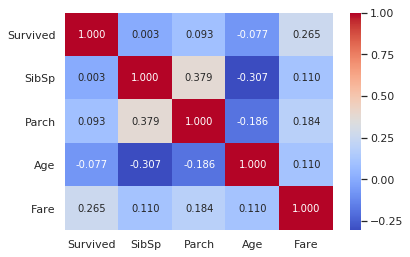

In [0]:
heatmap = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr() , annot=True , fmt=".3f" , cmap="coolwarm")

<h2>Numerical data Analysis</h2>

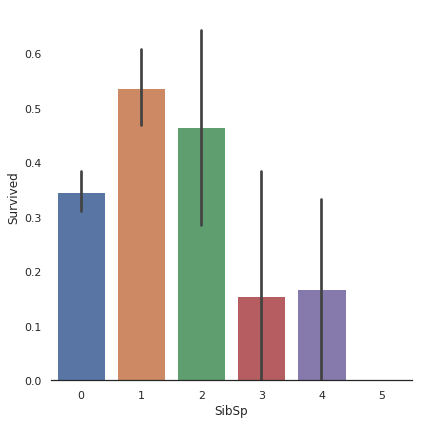

In [0]:
#SibSp
plot = sns.catplot(x='SibSp' , y='Survived' , data=train , kind='bar' , height=6)
plot.despine(left=True)

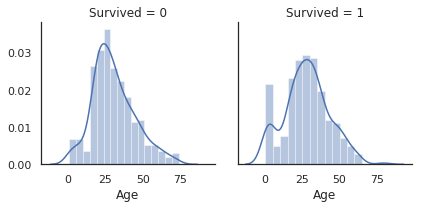

In [0]:
#Age
plot  = sns.FacetGrid(train , col='Survived')
plot = plot.map(sns.distplot , "Age")

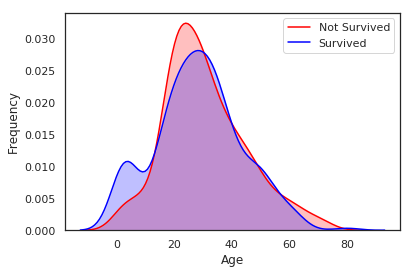

In [0]:
plot = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())] , color='Red' , shade=True)
plot = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax=plot, color="Blue", shade= True)
plot.set_xlabel("Age")
plot.set_ylabel("Frequency")
plot = plot.legend(["Not Survived","Survived"])

In [0]:
#Fare
dataset['Fare'].isnull().sum()

1

In [0]:
dataset['Fare'].fillna(dataset['Fare'].mean() , inplace=True)

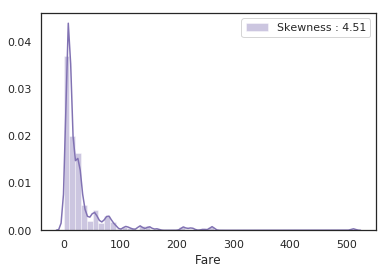

In [0]:
plot = sns.distplot(dataset['Fare'] , color='m' , label="Skewness : %.2f"%(dataset['Fare'].skew()))
plot = plot.legend(loc="best")

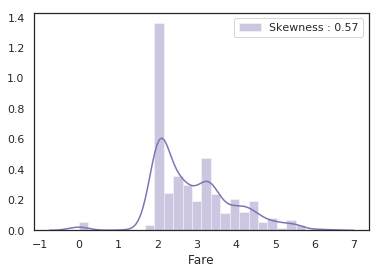

In [0]:
dataset['Fare'] = dataset['Fare'].map(lambda x:np.log(x) if x>0 else 0)
plot = sns.distplot(dataset['Fare'] , color='m' , label="Skewness : %.2f"%(dataset['Fare'].skew()))
plot = plot.legend(loc="best")

<h2>Categorical Values</h2>

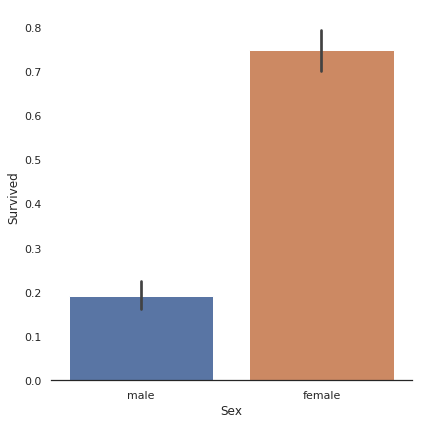

In [0]:
#Sex
plot = sns.catplot(x="Sex",y="Survived",data=train,kind="bar", height = 6)
plot.despine(left=True)

In [0]:
train[['Sex' , 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


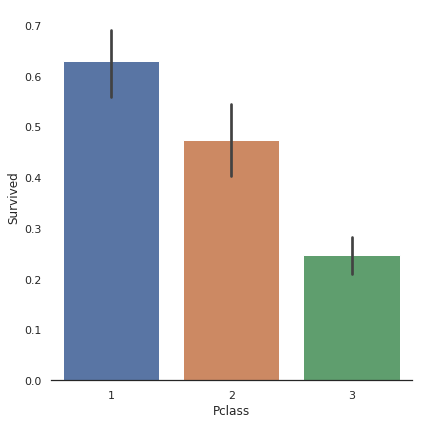

In [0]:
#Pclass
plot = sns.catplot(x="Pclass",y="Survived",data=train,kind="bar", height = 6)
plot.despine(left=True)

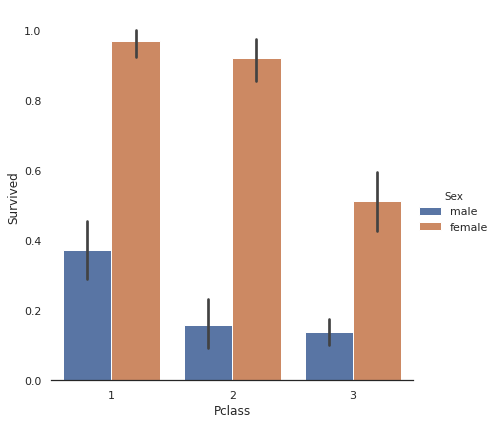

In [0]:
plot = sns.catplot(x="Pclass",y="Survived" , hue='Sex',data=train,kind="bar", height = 6)
plot.despine(left=True)

In [0]:
#Embarked
dataset['Embarked'].isnull().sum()

2

In [0]:
dataset['Embarked'].fillna(train['Embarked'].value_counts().idxmax() , inplace=True)

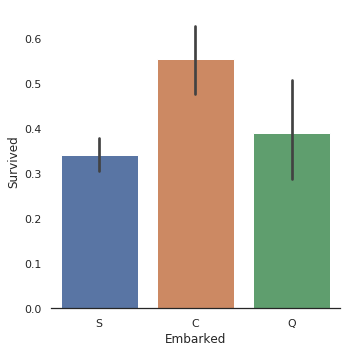

In [0]:
plot = sns.catplot(x='Embarked' , y='Survived' , data = train , kind='bar') 
plot.despine(left=True)

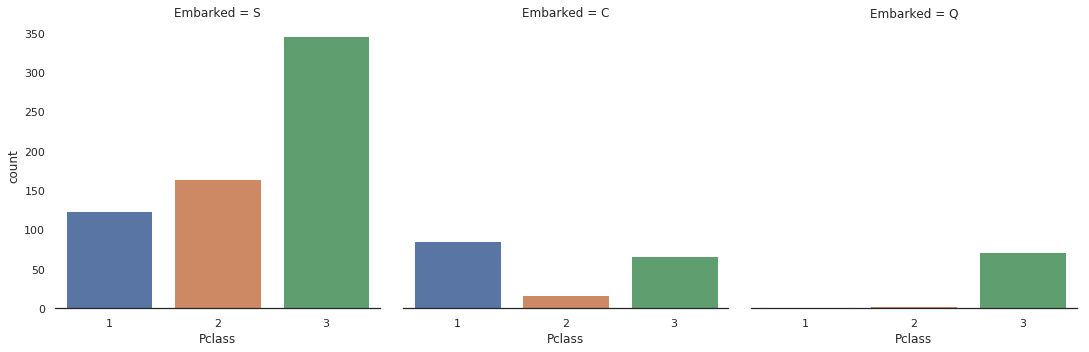

In [0]:
plot = sns.catplot('Pclass', col='Embarked' , data=train , kind='count')
plot.despine(left=True)

In [0]:
# plot = sns.catplot(x='Pclass', y='Survived' , col='Embarked' , data=train , kind='bar')
# plot.despine(left=True)

<h2>Filling Missing Values</h2>

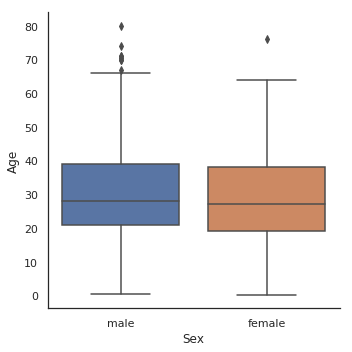

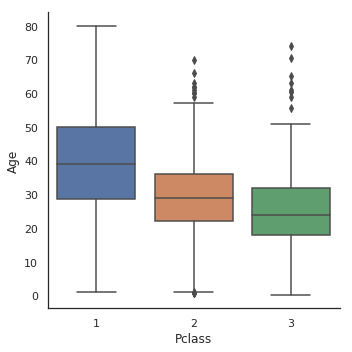

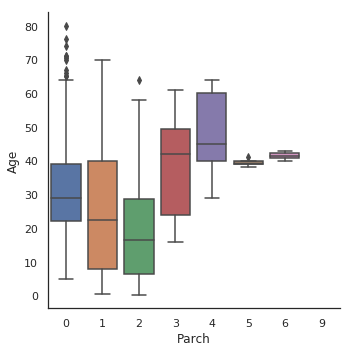

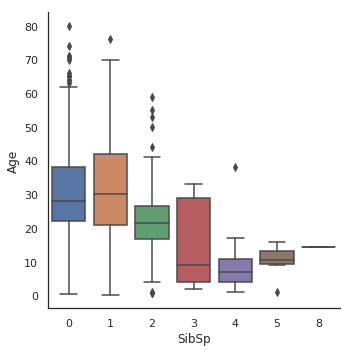

In [0]:
#Age


# Explore Age vs Sex, Parch , Pclass and SibSP
plot = sns.catplot(y="Age",x="Sex",data=dataset,kind="box")
plot = sns.catplot(y="Age",x="Pclass", data=dataset,kind="box")
plot = sns.catplot(y="Age",x="Parch", data=dataset,kind="box")
plot = sns.catplot(y="Age",x="SibSp", data=dataset,kind="box")

<p>This help to understand that we can predict Age on the basis of SibSp , Parch and Pclass</p>

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
train_X = dataset[['SibSp','Pclass','Parch']][dataset['Age'].notnull()]
train_y = dataset[['Age']][dataset['Age'].notnull()]
test_X = dataset[['SibSp','Pclass','Parch']][dataset['Age'].isnull()]
model = RandomForestRegressor(n_estimators=100,random_state=1)
model.fit(train_X , train_y)
prediction = np.round(model.predict(test_X),decimals=0)
dataset['Age'][dataset['Age'].isnull()] = prediction

<h1>Feature Engineering</h1>

In [0]:
dataset.rename(columns={'Name':'Title'} , inplace=True)
dataset['Title'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Title, dtype: object

In [0]:
#Name
unique_list = [name.split(',')[1].split('.')[0].strip() for name in dataset['Title']]
dataset['Title'] = pd.Series(unique_list)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [0]:
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col' , 'Sir']:
        return 'Mr'
    elif title in ['Mme' , 'the Countess']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms' , 'Lady' , 'Dona']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
dataset['Title']=dataset.apply(replace_titles, axis=1)
dataset['Title'].value_counts()

Mr        771
Miss      261
Mrs       207
Master     60
Name: Title, dtype: int64

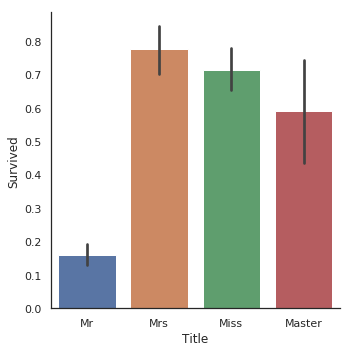

In [0]:
plot = sns.factorplot(x='Title' , y='Survived' , data=dataset , kind='bar')

In [0]:
#Family Size(new Feature)
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch']

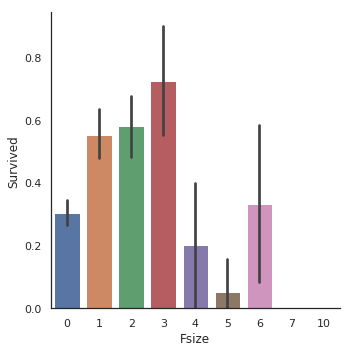

In [0]:
plot = sns.factorplot(x='Fsize' , y='Survived' , data=dataset , kind='bar')

In [0]:


# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 0 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  1<= s <= 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if s == 3 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 4 else 0)

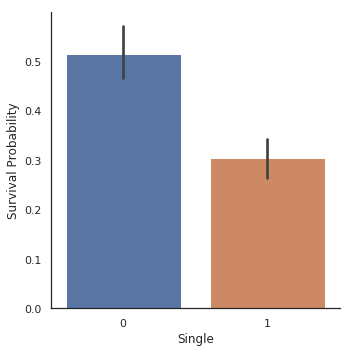

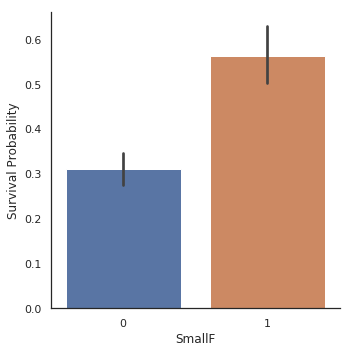

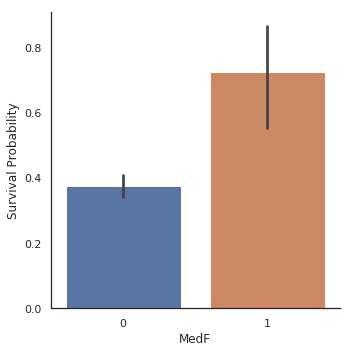

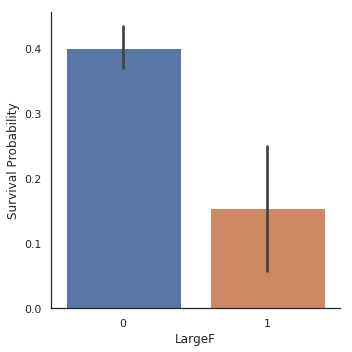

In [0]:
g = sns.factorplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")


In [0]:
#Apply onehot encoding
dataset = pd.get_dummies(dataset , columns=['Title' , 'Embarked'])
#Change Sex to 0 and 1
dataset['Sex'] = dataset['Sex'].map(lambda s:1 if s=='male' else 0)

In [0]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Fsize,Single,SmallF,MedF,LargeF,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,1,22.0,1,0,A/5 21171,1.981001,NaN,1,0,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,0,38.0,1,0,PC 17599,4.266662,C85,1,0,1,0,0,0,0,0,1,1,0,0
2,3,1.0,3,0,26.0,0,0,STON/O2. 3101282,2.070022,NaN,0,1,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,0,35.0,1,0,113803,3.972177,C123,1,0,1,0,0,0,0,0,1,0,0,1
4,5,0.0,3,1,35.0,0,0,373450,2.085672,NaN,0,1,0,0,0,0,0,1,0,0,0,1


In [0]:
#Cabin
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [0]:
dataset['Cabin'] = pd.Series(cabin[0] if not pd.isnull(cabin) else 'X' for cabin in dataset['Cabin'].values)

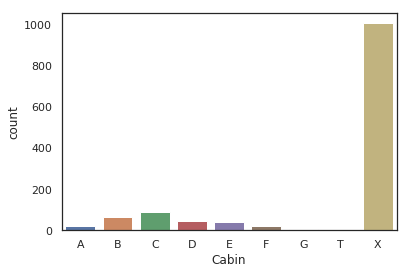

In [0]:
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

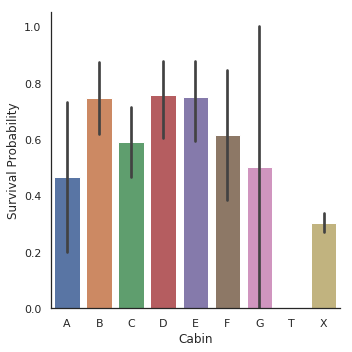

In [0]:
plot = sns.factorplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
plot = plot.set_ylabels("Survival Probability")

In [0]:
dataset = pd.get_dummies(dataset , columns=['Cabin'])

In [0]:
#Tickets
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [0]:
Tickets = []
for t in list(dataset.Ticket):
    if not t.isdigit():
        Tickets.append(t.split(" ")[0].replace(".","").replace("/","").strip())
    else:
        Tickets.append("X")
dataset['Ticket'] = pd.Series(Tickets)

In [0]:
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [0]:
dataset['Ticket'].value_counts()

X          954
PC          92
CA          61
A5          28
SOTONOQ     24
WC          15
STONO       14
SCPARIS     14
A4          10
FCC          9
SOC          8
C            8
STONO2       7
SOPP         7
SCAH         5
SCParis      5
PP           4
LINE         4
WEP          4
FC           3
SOTONO2      3
PPP          2
SC           2
SWPP         2
SCA4         2
LP           1
AS           1
SP           1
SOP          1
CASOTON      1
STONOQ       1
A            1
Fa           1
SCA3         1
SCOW         1
AQ4          1
AQ3          1
Name: Ticket, dtype: int64

In [0]:
dataset = pd.get_dummies(dataset , columns=['Pclass' , 'Ticket'])

In [0]:
dataset.drop(['PassengerId'] , axis=1 , inplace=True)

In [0]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,LargeF,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,Pclass_1,Pclass_2,Pclass_3,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,Ticket_LINE,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_PPP,Ticket_SC,Ticket_SCA3,Ticket_SCA4,Ticket_SCAH,Ticket_SCOW,Ticket_SCPARIS,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_X
0,0.0,1,22.0,1,0,1.981001,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,0,38.0,1,0,4.266662,1,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,0,26.0,0,0,2.070022,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1.0,0,35.0,1,0,3.972177,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0.0,1,35.0,0,0,2.085672,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
dataset.shape

(1299, 67)

<h1>Modeling</h1>

In [0]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop('Survived' , axis=1 , inplace=True)

In [0]:
train['Survived'] = train['Survived'].astype(int)
y_train = train['Survived']
X_train= train.drop('Survived', axis=1)

In [0]:
X_train.head()

,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,LargeF,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,Pclass_1,Pclass_2,Pclass_3,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,Ticket_LINE,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_PPP,Ticket_SC,Ticket_SCA3,Ticket_SCA4,Ticket_SCAH,Ticket_SCOW,Ticket_SCPARIS,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_X
0,1,22.0,1,0,1.981001,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,38.0,1,0,4.266662,1,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,26.0,0,0,2.070022,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,35.0,1,0,3.972177,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,35.0,0,0,2.085672,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [0]:
# random_state=1
# classifiers = []
# classifiers.append(SVC(random_state=random_state))
# classifiers.append(DecisionTreeClassifier(random_state=random_state))
# classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
# classifiers.append(RandomForestClassifier(random_state=random_state))
# classifiers.append(GradientBoostingClassifier(random_state=random_state))
# classifiers.append(KNeighborsClassifier())
# classifiers.append(LogisticRegression(random_state = random_state))
# classifiers.append(XGBClassifier(n_estimator =100, random_state=random_state))

# cv_scores = []
# for classifier in classifiers:
#     cv_scores.append(cross_val_score(classifier , X_train , y=y_train , scoring='accuracy' , cv=10 , n_jobs=4).mean())
# print(cv_scores)

# cv_df = pd.DataFrame({"CrossValMeans":cv_scores,"Algorithm":["SVC","DecisionTree","AdaBoost","RandomForest","GradientBoosting"
#                      ,"KNeighboors","LogisticRegression","XGBClassifier"]})
# plot = sns.barplot(x='CrossValMeans' , y='Algorithm' , data=cv_df , orient='h')

<h2>Feature Selection</h2>

In [0]:
#Using XGBoost
from matplotlib import pyplot
from xgboost import plot_importance
model = XGBClassifier(n_estimater=100  , random_state=2)
model.fit(X_train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimater=100,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=2, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [0]:
importance_features = model.feature_importances_
importance_df = pd.DataFrame({"features":X_train.columns , "importance":importance_features})
importance_df = importance_df.sort_values(by='importance' , ascending=False).reset_index(drop=True)

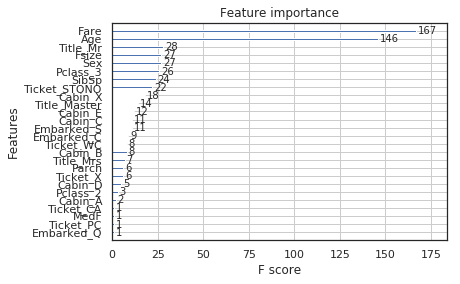

In [0]:
plot_importance(model)

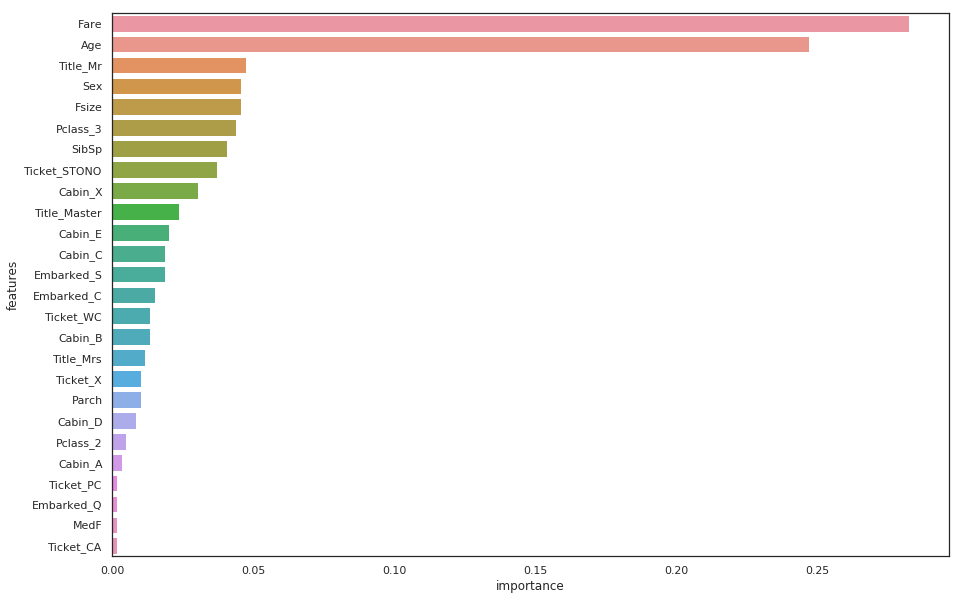

In [0]:
pyplot.figure(figsize=(15,10))
plot = sns.barplot(x='importance' , y='features' , orient='h' , data=importance_df[:26])

In [0]:
from matplotlib import pyplot
from xgboost import plot_importance
XGB_model = XGBClassifier(n_estimators=100  , random_state=2)
#Choise Best Features
def getBestFeature(model , X_train , y_train , plot=False , feature_num=0 , F_range=[0,0]):
    model.fit(X_train,y_train)
    important_features = model.feature_importances_
    importance_df = pd.DataFrame({"features":X_train.columns , "importance":important_features})
    importance_df = importance_df.sort_values(by='importance' , ascending=False).reset_index(drop=True)
    #Plot the Features
    if plot==True:
        pyplot.figure(figsize=(15,10))
        plot = sns.barplot(x='importance' , y='features' , orient='h' , data=importance_df[:feature_num])
        pyplot.show()
    #Get the Best Features
    accuracy = []
    feature_len=[]    
    for i in range(1,int(len(important_features))):
        feature_len.append(i)
    feature_len.append(len(important_features))
    for F_len in feature_len:
        features = importance_df['features'][:F_len]
        accuracy.append(cross_val_score(model, X_train[features], y = y_train, scoring = "accuracy", cv = 10, n_jobs=4).mean())
    print(accuracy,feature_len)
    df = pd.DataFrame({"feature_len":feature_len , "accuracy":accuracy})
    pyplot.close()
    plot = pyplot.plot(df['feature_len'] , accuracy)
    return (importance_df['features'][:feature_len[accuracy.index(max(accuracy))]] , max(accuracy))

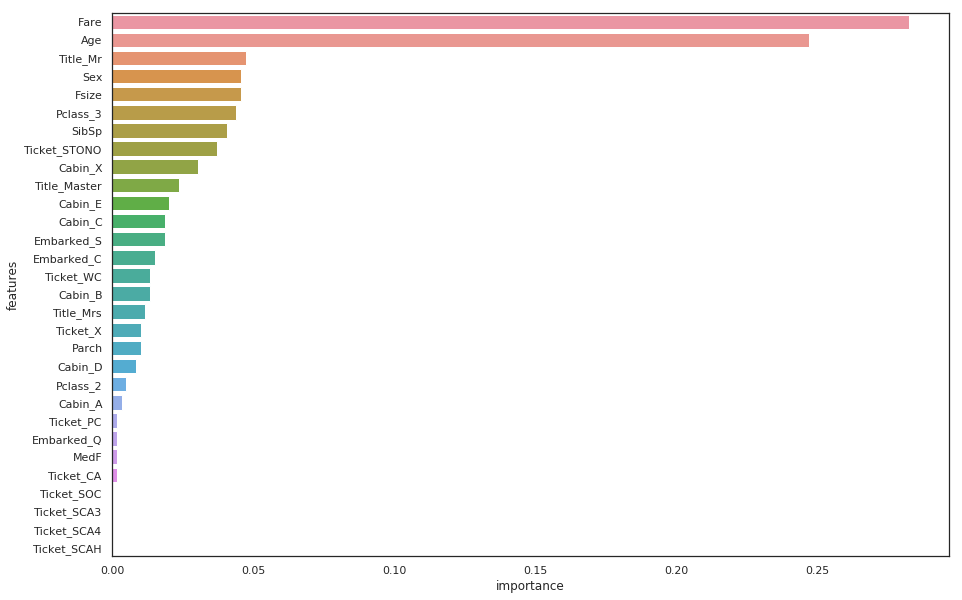

[0.6925306435137897, 0.7038687436159345, 0.8104698672114402, 0.8025025536261492, 0.8342568947906026, 0.8331460674157304, 0.8410750766087846, 0.8376787538304393, 0.8308733401430031, 0.8342824310520941, 0.8365551583248212, 0.8377042900919305, 0.8308988764044944, 0.8240806945863126, 0.8297497446373852, 0.8286133810010214, 0.8308988764044944, 0.828626149131767, 0.8331588355464759, 0.8263534218590397, 0.8320097037793666, 0.8263534218590397, 0.8286006128702759, 0.8308733401430033, 0.8308733401430031, 0.8320097037793668, 0.8320097037793668, 0.8320097037793668, 0.8320097037793668, 0.8320097037793668, 0.8320097037793668, 0.8320097037793668, 0.8320097037793668, 0.8320097037793668, 0.8320097037793668, 0.8320097037793668, 0.8320097037793668, 0.8320097037793668, 0.8320097037793668, 0.8320097037793668, 0.8320097037793668, 0.8320097037793668, 0.8320097037793668, 0.8320097037793668, 0.8320097037793668, 0.8320097037793668, 0.8320097037793668, 0.8320097037793668, 0.8331460674157304, 0.8331460674157304, 

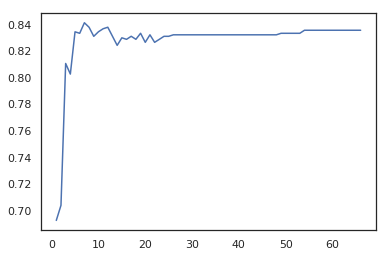

In [0]:
Best_features_XGB , Best_acc_XGB = getBestFeature(XGB_model ,X_train , y_train , plot=True , feature_num=30)

In [0]:
print(Best_features_XGB)
print("Best_acc :", Best_acc_XGB)

0        Fare
1         Age
2    Title_Mr
3         Sex
4       Fsize
5    Pclass_3
6       SibSp
Name: features, dtype: object
Best_acc : 0.8410750766087846


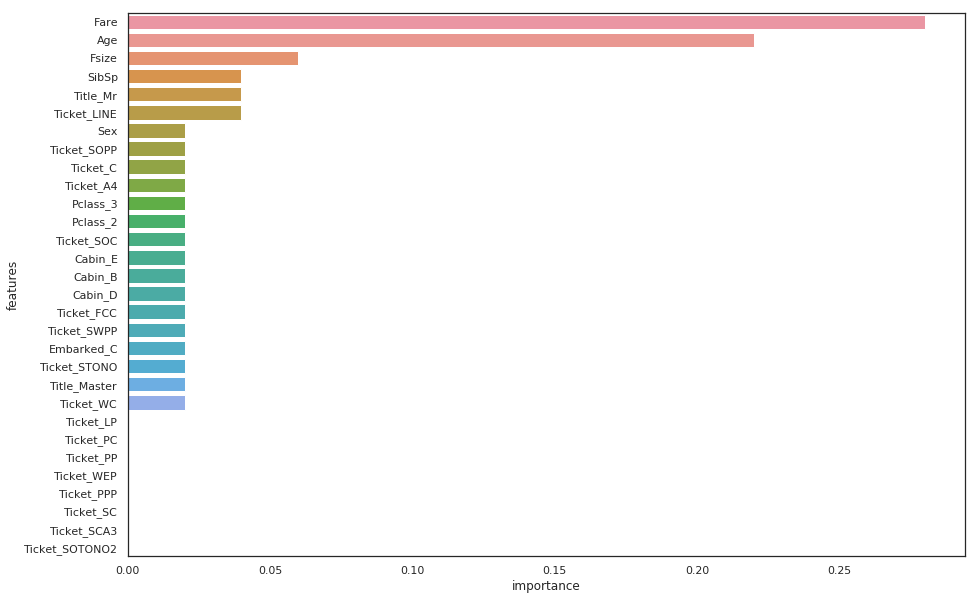

[0.6721016343207354, 0.690232379979571, 0.6992849846782431, 0.6958631256384067, 0.8138278855975484, 0.807035240040858, 0.8070224719101123, 0.80591164453524, 0.8036261491317672, 0.7990934627170583, 0.8115806945863125, 0.8138534218590399, 0.8093079673135855, 0.8104570990806946, 0.8138661899897854, 0.8195097037793667, 0.8195097037793667, 0.8240806945863126, 0.8172752808988765, 0.8229315628192031, 0.8161133810010215, 0.8217951991828396, 0.8217951991828396, 0.820658835546476, 0.820658835546476, 0.817249744637385, 0.817249744637385, 0.817249744637385, 0.817249744637385, 0.817249744637385, 0.817249744637385, 0.817249744637385, 0.817249744637385, 0.817249744637385, 0.817249744637385, 0.817249744637385, 0.817249744637385, 0.817249744637385, 0.817249744637385, 0.817249744637385, 0.817249744637385, 0.817249744637385, 0.817249744637385, 0.8195480081716037, 0.8195480081716037, 0.81841164453524, 0.81841164453524, 0.81841164453524, 0.81841164453524, 0.8183988764044944, 0.8183988764044944, 0.819535240

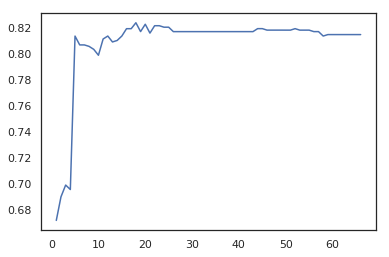

In [0]:
Ada_model = AdaBoostClassifier()
Best_features_Ada , Best_acc_Ada = getBestFeature(Ada_model , X_train , y_train , plot=True , feature_num=30)

In [0]:
print(Best_features_Ada )
print("Best_acc :",Best_acc_Ada)

0            Fare
1             Age
2           Fsize
3           SibSp
4        Title_Mr
5     Ticket_LINE
6             Sex
7     Ticket_SOPP
8        Ticket_C
9       Ticket_A4
10       Pclass_3
11       Pclass_2
12     Ticket_SOC
13        Cabin_E
14        Cabin_B
15        Cabin_D
16     Ticket_FCC
17    Ticket_SWPP
Name: features, dtype: object
Best_acc : 0.8240806945863126


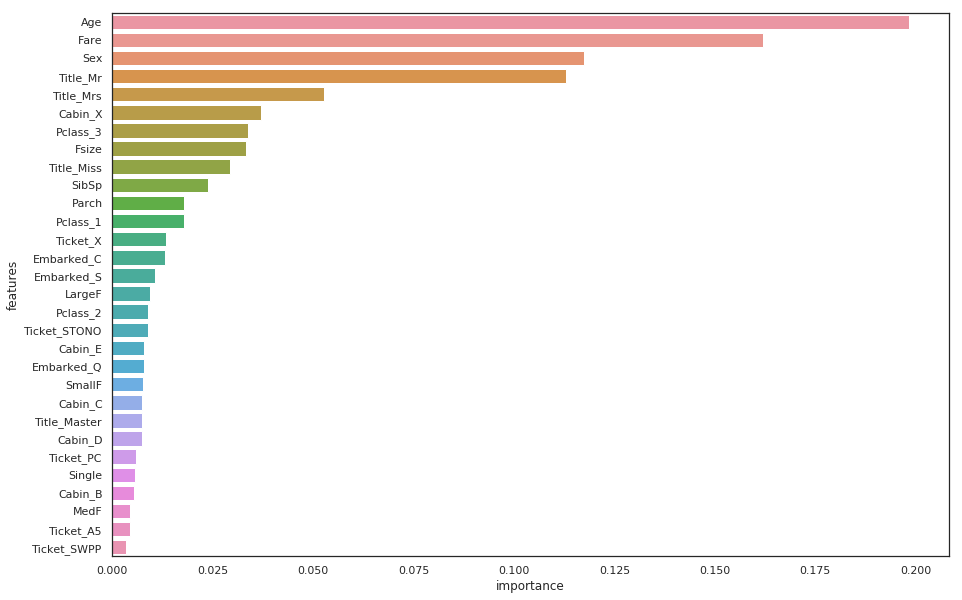

[0.5879596527068438, 0.6481230847803883, 0.7832482124616955, 0.779826353421859, 0.7844101123595506, 0.8002425944841676, 0.8195735444330949, 0.8059499489274768, 0.8128192032686415, 0.8161389172625126, 0.8127936670071501, 0.818449948927477, 0.8162027579162411, 0.7968335035750767, 0.8002425944841676, 0.8081971399387129, 0.8184116445352402, 0.8127298263534218, 0.8048008171603677, 0.8116573033707866, 0.8070224719101123, 0.8002681307456587, 0.7957609805924413, 0.8127042900919305, 0.8138789581205312, 0.8047752808988765, 0.8013661899897855, 0.8047880490296221, 0.8013917262512769, 0.8149642492339122, 0.8127298263534218, 0.817249744637385, 0.8173008171603678, 0.8150025536261492, 0.7923135852911133, 0.8070607763023494, 0.8343207354443308, 0.7979954034729315, 0.8081971399387131, 0.802502553626149, 0.7957099080694586, 0.7934371807967314, 0.8059116445352401, 0.8149514811031665, 0.8070224719101123, 0.8048518896833503, 0.7968462717058225, 0.8161644535240041, 0.8059371807967313, 0.8104187946884578, 0.7

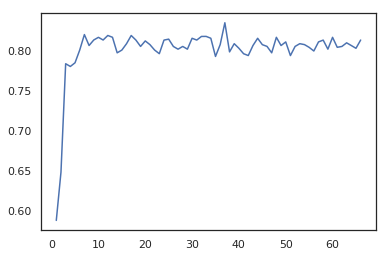

In [0]:
RF_model = RandomForestClassifier()
Best_features_RF,Best_acc_RF = getBestFeature(RF_model , X_train , y_train , plot=True , feature_num=30)

In [0]:
print(Best_features_RF,Best_acc_RF)

0               Age
1              Fare
2               Sex
3          Title_Mr
4         Title_Mrs
5           Cabin_X
6          Pclass_3
7             Fsize
8        Title_Miss
9             SibSp
10            Parch
11         Pclass_1
12         Ticket_X
13       Embarked_C
14       Embarked_S
15           LargeF
16         Pclass_2
17     Ticket_STONO
18          Cabin_E
19       Embarked_Q
20           SmallF
21          Cabin_C
22     Title_Master
23          Cabin_D
24        Ticket_PC
25           Single
26          Cabin_B
27             MedF
28        Ticket_A5
29      Ticket_SWPP
30          Cabin_A
31        Ticket_WC
32         Ticket_C
33          Cabin_G
34    Ticket_STONO2
35        Ticket_CA
36       Ticket_SOC
Name: features, dtype: object 0.8343207354443308


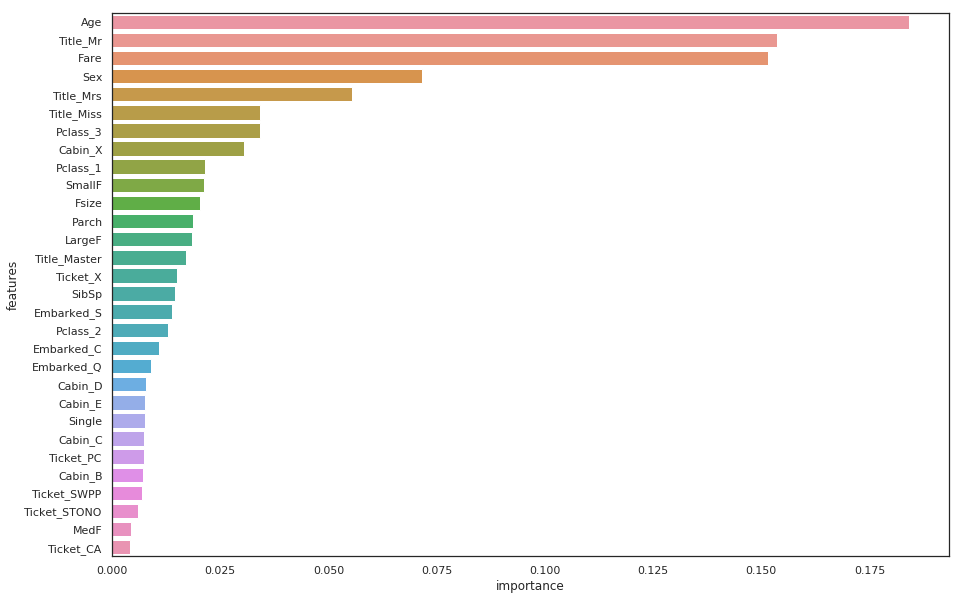

[0.6061159346271705, 0.7729698672114401, 0.7821246169560776, 0.7594228804902963, 0.7719484167517875, 0.7571629213483146, 0.8093079673135852, 0.824067926455567, 0.811567926455567, 0.7969101123595506, 0.794611848825332, 0.8036899897854954, 0.8025536261491318, 0.7991445352400408, 0.8002425944841676, 0.7980337078651685, 0.7889044943820225, 0.7956843718079674, 0.7889172625127682, 0.7945607763023494, 0.7957354443309499, 0.7956843718079674, 0.7900408580183861, 0.794573544433095, 0.7855081716036771, 0.7911772216547497, 0.794535240040858, 0.7854570990806946, 0.7991317671092952, 0.8104698672114402, 0.8048263534218592, 0.8059499489274771, 0.8025025536261492, 0.8116062308478039, 0.8047752808988765, 0.7934499489274769, 0.8025153217568948, 0.8024897854954034, 0.7957099080694586, 0.8002425944841676, 0.7911772216547497, 0.8048391215526047, 0.8070863125638408, 0.7980209397344229, 0.7968718079673136, 0.8025153217568948, 0.7968590398365679, 0.7923008171603677, 0.8081971399387131, 0.8081971399387129, 0.79

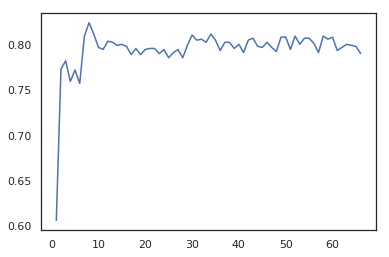

In [0]:
Extree_model = ExtraTreesClassifier()
Best_features_Extree,Best_acc_Extree = getBestFeature(Extree_model , X_train , y_train , plot=True , feature_num=30)

In [0]:
print(Best_features_Extree,Best_acc_Extree)

0           Age
1      Title_Mr
2          Fare
3           Sex
4     Title_Mrs
5    Title_Miss
6      Pclass_3
7       Cabin_X
Name: features, dtype: object 0.824067926455567


In [0]:
# Knn_model = KNeighborsClassifier()
# Best_features_Knn,Best_acc_Knn = getBestFeature(Knn_model , X_train , y_train , plot=True , feature_num=30)

In [0]:
# print(Best_features_knn,Best_acc_knn)

In [0]:
# svm_model = SVC()
# Best_features_svc,Best_acc_svc = getBestFeature(svm_model , X_train , y_train , plot=True , feature_num=30)

In [0]:
# Best_Features = getBestFeature_BeingGreedy(model ,X_train , y_train , plot=True , feature_num=30)

In [0]:
#range(1,250,10), gamma=0.05, learning_rate=0.08,n_estimators=231
#np.round(np.linspace(0 , 0.3 , 19) , 2), 'gamma':[0.01,0.05,0.1,0.5]
XGB = XGBClassifier()
gb_param_grid = {
              'n_estimators' :[231],
              'learning_rate':[0.08],
                'gamma':[0.05]
              }

gsXGB = GridSearchCV(XGB,param_grid = gb_param_grid, cv=10, scoring="accuracy", n_jobs= 4, verbose = 1)

gsXGB.fit(X_train[Best_features_XGB],y_train)

XGB_best = gsXGB.best_estimator_
#n_estimators=61
#learning_rate=0.22
# Best score
gsXGB.best_score_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.0s finished


0.8513053348467651

In [0]:
def tuneParams(classifier,params,train_x,train_y):
    md = GridSearchCV(classifier,params,cv=10,scoring='accuracy',n_jobs=-1)
    md.fit(train_x,train_y)
    best_params,best_score = md.best_params_,np.round(md.best_score_*100,2)
    
    return best_params,best_score , md.best_estimator_

In [0]:
# ABParams = {'n_estimators':range(1,500,25),'learning_rate':[0.1,0.2,0.3,0.22,0.01,0.02,0.03,0.04,0.05]}
# RFParams = {'n_estimators':[5,10,15,20,25,30,35,40,45,50],'max_depth':[3,5,8,10],'min_samples_split':[2,5,10],'min_samples_leaf':[2,4,10],'random_state':[5]}
# ETParams = {'n_estimators':range(1,500,25),'max_depth':[3,8,12],'min_samples_leaf':[2,4,9],'verbose':[0]}
#KNNParams = {'n_neighbors':[3,8,14],'leaf_size':[2,5,9],'weights':['uniform']}
# SVCParams = {'C':[0.01,0.1,0.5],'gamma':[0.01,0.2]}
ABParams= {'learning_rate': [0.1], 'n_estimators': [250]} 
RFParams= {'max_depth': [8], 'min_samples_leaf': [2], 'min_samples_split': [5], 'n_estimators': [1], 'random_state': [5]}
ETParams= {'max_depth': [12], 'min_samples_leaf': [2], 'n_estimators': [300], 'verbose': [0]}
KNNParams= {'leaf_size': [2], 'n_neighbors': [3], 'weights': ['uniform']} 
SVCParams= {'C': [0.5], 'gamma':[0.2]}
# AdaBoost: {'learning_rate': 0.1, 'n_estimators': 250} 82.97
# RandomForest: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10, 'random_state': 5} 84.11
# ExtraTrees: {'max_depth': 12, 'min_samples_leaf': 2, 'n_estimators': 300, 'verbose': 0} 83.88
# SVC: {'C': 0.5, 'gamma': 0.2} 80.02

In [0]:
processed_train_data = X_train
TargetLabel = y_train
AB_best_Params,AB_best_score,ada_Best = tuneParams(AdaBoostClassifier(),ABParams,processed_train_data[Best_features_Ada],TargetLabel)
print("AdaBoost:",AB_best_Params,AB_best_score)
RF_best_Params,RF_best_score,RF_best = tuneParams(RandomForestClassifier(),RFParams,processed_train_data[Best_features_RF],TargetLabel)
print("RandomForest:",RF_best_Params,RF_best_score)
ET_best_Params,ET_best_score,ExtC_best = tuneParams(ExtraTreesClassifier(),ETParams,processed_train_data[Best_features_Extree],TargetLabel)
print("ExtraTrees:",ET_best_Params,ET_best_score)
# KNN_best_Params,KNN_best_score,KNN_best = tuneParams(KNeighborsClassifier(),KNNParams,processed_train_data,TargetLabel)
# print("KNeighbors:",KNN_best_Params,KNN_best_score)
# SVC_best_Params,SVC_best_score,SVMC_best = tuneParams(SVC(),SVCParams,processed_train_data,TargetLabel)
# print("SVC:",SVC_best_Params,SVC_best_score)



AdaBoost: {'learning_rate': 0.1, 'n_estimators': 250} 82.97
RandomForest: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1, 'random_state': 5} 77.75
ExtraTrees: {'max_depth': 12, 'min_samples_leaf': 2, 'n_estimators': 300, 'verbose': 0} 82.86


In [0]:
# votingC = VotingClassifier(estimators=[ ('extc', ExtC_best),
# ('svc', SVMC_best), ('adac',ada_Best),('rf',RF_best),('knn',KNN_best)], voting='soft', n_jobs=4)

# votingC = votingC.fit(X_train, y_train)
# votingC 'SVM':SVMC_best.predict(test)
prediction_df = pd.DataFrame({'Xgboot':XGB_best.predict(test[Best_features_XGB]) ,'Ada':ada_Best.predict(test[Best_features_Ada]) , 
                              'RandomForest':RF_best.predict(test[Best_features_RF]) , 'ExtraTrees':ExtC_best.predict(test[Best_features_Extree])
                              })
training_prediction = pd.DataFrame({'Xgboot':XGB_best.predict(X_train[Best_features_XGB]) ,'Ada':ada_Best.predict(X_train[Best_features_Ada]) , 
                              'RandomForest':RF_best.predict(X_train[Best_features_RF]) , 'ExtraTrees':ExtC_best.predict(X_train[Best_features_Extree])
                              })

In [0]:
from sklearn.metrics import accuracy_score
training_prediction['Final_test'] = (training_prediction.sum(axis=1))/len(prediction_df.columns)
training_prediction['Final_test'] = training_prediction['Final_test'].map(lambda x: 1 if x>=0.5 else 0)
for columns in training_prediction.columns:
    print("training_score" , accuracy_score(y_train , training_prediction[columns]))
training_prediction

training_score 0.8910329171396141
training_score 0.8422247446083996
training_score 0.8399545970488081
training_score 0.8717366628830874
training_score 0.8671963677639046


,Xgboot,Ada,RandomForest,ExtraTrees,Final_test
0,0,0,0,0,0
1,1,1,1,1,1
2,1,1,1,1,1
3,1,1,1,1,1
4,0,0,0,0,0
5,0,0,0,0,0
6,0,1,0,0,0
7,0,0,0,0,0
8,1,1,0,1,1
9,1,1,1,1,1


In [0]:
prediction_df['Final_test'] = (prediction_df.sum(axis=1))/len(prediction_df.columns)
prediction_df['Final_test'] = prediction_df['Final_test'].map(lambda x: 1 if x>=0.5 else 0)
prediction_df

,Xgboot,Ada,RandomForest,ExtraTrees,Final_test
0,0,0,0,0,0
1,0,1,1,1,1
2,0,0,0,0,0
3,0,0,0,0,0
4,1,1,0,1,1
5,0,0,0,0,0
6,0,1,1,1,1
7,0,0,0,0,0
8,1,1,1,1,1
9,0,0,0,0,0


In [0]:
print(XGB_best)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.05, learning_rate=0.08,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=231, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)


In [0]:
my_submission = pd.DataFrame({'PassengerId': IDtest, 'Survived':prediction_df['Final_test'] })
my_submission.to_csv('submission.csv', index=False)